# CycleGAN


The goal of the exercise is to implement and train a simple version of [CycleGAN](https://arxiv.org/abs/1703.10593).

It is a GAN image to image translation architecture.  It's key feature is that we can train it using unpaired images.

For more information on CycleGAN see [tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan) and [keras implementation](https://keras.io/examples/generative/cyclegan/).

In [2]:
import os

from pathlib import Path
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as TT

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

In [22]:
def cross_entropy_custom(y_hat, y):
    s = 0
    for i in range(len(y)):
        s -= np.nan_to_num(y[i]*np.log(y_hat[i]))
    return s

a = [0.8, 0.2, 0.2, 0]
b = [0, 1, 0, 0]

cross_entropy_custom(a, b)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


1.6094379124341003

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 5.4 MB/s 
     |████████████████████████████████| 140 kB 40.1 MB/s 
     |████████████████████████████████| 596 kB 6.1 MB/s 
     |████████████████████████████████| 409 kB 11.7 MB/s 
     |████████████████████████████████| 1.1 MB 37.2 MB/s 
     |████████████████████████████████| 144 kB 37.0 MB/s 
     |████████████████████████████████| 271 kB 37.0 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pytorch_lightning as pt

In [ ]:
!wget https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/horse2zebra.zip
!unzip horse2zebra.zip

--2022-05-24 09:27:15--  https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  49.7MB/s    in 2.2s    

2022-05-24 09:27:17 (49.7 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]

Archive:  horse2zebra.zip
   creating: horse2zebra/
   creating: horse2zebra/trainA/
  inflating: horse2zebra/trainA/n02381460_6223.jpg  
  inflating: horse2zebra/trainA/n02381460_1567.jpg  
  inflating: horse2zebra/trainA/n02381460_3354.jpg  
  inflating: horse2zebra/trainA/n02381460_299.jpg  
  inflating: horse2zebra/trainA/n02381460_3001.jpg  
  inflating: horse2zebra/trainA/n02381460_4242.jpg  
  inflating: horse2zebra/tra

In [ ]:
!ls

horse2zebra  horse2zebra.zip  sample_data


In [ ]:
# Define the standard image size.
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (128, 128, 3)

In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, root: Path, transforms):
        self.root = root
        self.transforms = transforms
        self.paths = sorted(list(self.root.glob("*")))

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")

        if self.transforms is not None:
            img = self.transforms(img)

        return img

    def __len__(self):
        return len(self.paths)

In [ ]:
def get_transforms_train():
    trans = [
        TT.ToTensor(),
        TT.RandomHorizontalFlip(),
        TT.Resize(orig_img_size[:2]),
        TT.RandomCrop(input_img_size[:2]),
        TT.Normalize((0.5, 0.5, 0.5), (0.225, 0.225, 0.225))
    ]
    return TT.Compose(trans)

def get_transforms_test():
    trans = [
        TT.ToTensor(),
        TT.Resize(input_img_size[:2]),
        TT.Normalize((0.5, 0.5, 0.5), (0.225, 0.225, 0.225))
    ]
    return TT.Compose(trans)

In [ ]:
ROOT = Path("horse2zebra/")


tr_data_horses = ImagesDataset(ROOT / "trainA", get_transforms_train())
tr_data_zebras = ImagesDataset(ROOT / "trainB", get_transforms_train())

test_data_horses = ImagesDataset(ROOT / "trainA", get_transforms_test())
test_data_zebras = ImagesDataset(ROOT / "trainB", get_transforms_test())

batch_size_tr = 8
batch_size_test = 8
train_dataloader_horses = DataLoader(tr_data_horses, batch_size=batch_size_tr, shuffle=True)
train_dataloader_zebras = DataLoader(tr_data_zebras, batch_size=batch_size_tr, shuffle=True)
test_dataloader_horses = DataLoader(test_data_horses, batch_size=batch_size_test, shuffle=False)
test_dataloader_zebras = DataLoader(test_data_zebras, batch_size=batch_size_test, shuffle=False)


In [ ]:
import torchvision

def denormalize(img):
  return img*0.225 + 0.5

def show_sample(dataloader):
  imgs = next(iter(dataloader))
  imgs = denormalize(imgs[:8])
  grid = torchvision.utils.make_grid(imgs)

  plt.imshow(grid.numpy().transpose([1, 2, 0]))
  plt.show()

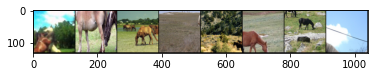

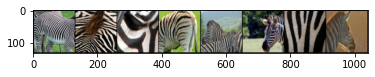

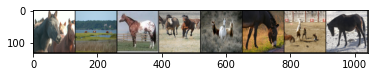

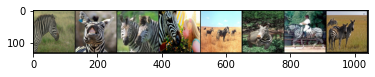

In [ ]:
show_sample(train_dataloader_horses)
show_sample(train_dataloader_zebras)
show_sample(test_dataloader_horses)
show_sample(test_dataloader_zebras)

# Neural Networks
Implement Generator (simple UNet architecture for image to image translation)  and Discriminator (simple classifier


In [ ]:
from torch.nn.modules.conv import Conv2d


class ConvBlock(nn.module):
    def __init__(self, in_channels, out_channels, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=3, 
                stride=stride, 
                padding=padding
            ),
            nn.BatchNorm2(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
  (...)
      

class UNet(nn.Module):
    def __init__(self, in_channels):
        super(UNet, self).__init__()
        self.depth0
        self.depth1
        self.depth2
        self.depth3
        self.depth4

        self.downsamplers = nn.ModuleList(
            [
                nn.MaxPool2d(3, 2, 1)
                for _ in range(5)
            ]
        )
        self.upsamplers = nn.MoudleList(
            [
                nn.Sequential(
                    nn.UpsamplingNearest2d(2),
                    nn.Conv2d(in_channels*2**-i, in_channels*2**-(i+1), 3, 1, 1)
                )
                for i in range(5)
            ]
        )




In [ ]:
test_ch = 

In [ ]:
gen_G = UNet(num_resblocks=3)
gen_F = UNet(num_resblocks=3)

disc_X = Discriminator()
disc_Y = Discriminator()

In [ ]:
x = next(iter(train_dataloader_horses))
res = gen_G(x)
print(res.shape)
res2 = disc_X(res)
print(res2.shape)

In [ ]:
adv_loss_fn = torch.nn.MSELoss()

def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(torch.ones_like(fake), fake)
    return fake_loss

def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(torch.ones_like(real), real)
    fake_loss = adv_loss_fn(torch.zeros_like(fake), fake)
    return (real_loss + fake_loss) / 2

identity_loss_fn = torch.nn.L1Loss()
cycle_loss_fn = torch.nn.L1Loss()


# Training
Define optimizers and implement training_step. Use loss defined above.

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
from pytorch_lightning.trainer.supporters import CombinedLoader

LR = 0.001
LR_DECAY = 0.93
EPOCHS = 20
lambda_cycle = 10
lambda_identity = 0.5
ACCELEREATOR = "gpu" # 'cpu' or 'gpu'  # MODIFY ME
FAST_DEV_RUN = False
DETECT_ANOMALY = False


class CycleGAN(pt.LightningModule):
    def __init__(self, gen_G, gen_F, disc_X, disc_Y):
        super().__init__()
        self.gen_G = gen_G
        self.gen_F = gen_F
        self.disc_X = disc_X
        self.disc_Y = disc_Y
        self.automatic_optimization = False

    def train_dataloader(self):

        H =  train_dataloader_horses
        Z =  train_dataloader_zebras

        loaders = {"H_tr": H, "Z_tr": Z}

        return loaders
    
    def val_dataloader(self):

        H =  test_dataloader_horses
        Z =  test_dataloader_zebras

        loaders = CombinedLoader({"H_val": H, "Z_val": Z})

        return loaders

    def on_epoch_start(self):
        for i in range(len(self.lr_schedulers())):
          self.log(f"lr{i}", self.lr_schedulers()[i].get_last_lr()[0])

    def on_epoch_end(self):
        [s.step() for s in self.lr_schedulers()]
    

    def training_step(self, batch, batch_idx):

        real_x, real_y = batch["H_tr"], batch["Z_tr"]

        # TODO (...)


        loss = total_loss_GF + disc_X_loss + disc_Y_loss

        self.log('total_loss_GF', total_loss_GF)

        self.logger.experiment.add_scalars('Disc Loss', 
                                           {'X': disc_X_loss, 
                                            'Y': disc_Y_loss}, 
                                           global_step=self.global_step)
        self.logger.experiment.add_scalars('Gen Loss', 
                                           {'gen_G_loss': gen_G_loss, 
                                            'cycle_loss_G': cycle_loss_G,
                                            'id_loss_G': id_loss_G,
                                            'gen_F_loss': gen_F_loss, 
                                            'cycle_loss_F': cycle_loss_F,
                                            'id_loss_F': id_loss_F,
                                            }, 
                                           global_step=self.global_step)

        self.log('loss', loss)

        return loss

    def configure_optimizers(self):
        from itertools import chain
        opt_GF = torch.optim.RMSprop(chain(self.gen_G.parameters(), self.gen_F.parameters()), lr=LR)
        opt_disc_X = torch.optim.RMSprop(self.disc_X.parameters(), lr=LR)
        opt_disc_Y = torch.optim.RMSprop(self.disc_Y.parameters(), lr=LR)
        optims = [opt_GF, opt_disc_X, opt_disc_Y]
        return optims , [ExponentialLR(optim, gamma=LR_DECAY) for optim in optims]

    def validation_step(self, batch, batch_idx):
        real_x, real_y = batch["H_val"], batch["Z_val"]

        fake_y = self.gen_G(real_x)
        
        ori_grid = torchvision.utils.make_grid(real_x)
        res_grid = torchvision.utils.make_grid(fake_y)

        self.logger.experiment.add_image(f'origin{batch_idx}', denormalize(ori_grid), global_step=self.global_step)
        self.logger.experiment.add_image(f'output{batch_idx}', denormalize(res_grid), global_step=self.global_step)


    def predict_step(self, batch, batch_idx):
        raise NotImplementedError()




In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger


logger = TensorBoardLogger("tb_logs", name="my_model")

model = CycleGAN(gen_G, gen_F, disc_X, disc_Y)

trainer = pt.Trainer(max_epochs=EPOCHS,
                     logger=logger,
                     check_val_every_n_epoch=2,
                     accelerator=ACCELEREATOR,
                     detect_anomaly=DETECT_ANOMALY,
                     fast_dev_run=FAST_DEV_RUN,
                     profiler='simple',
                    #  limit_train_batches=100,
                     limit_val_batches=1
                     )

trainer.fit(model)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir tb_logs

In [ ]:
trainer.save_checkpoint("simple_ssd.ckpt")

In [ ]:
!ls tb_logs

In [ ]:
!ls tb_logs/my_model

In [ ]:
# !rm -r tb_logs